In [2]:
import numpy as np
from matplotlib import pyplot as plt

In this notebook, we shall attempt to sample the dataset and visualize all trajectories, by region. This helps validate the flows identified by Zarya.

In [3]:
def get_region_bounds(region: str) -> tuple:
    # Get the geographical boundaries for the map 
    if region=='conus':
        # Contiguous United States
        lat_bounds = [23, 51]
        lon_bounds = [-130, -65]
    elif region=='europe':
        # Europe, from Portugal to Greece, not including Russia
        lat_bounds = [34, 72]        
        lon_bounds = [-32, 40]
    else:
        raise ValueError(f"Region {region} not recognized. Use 'conus' or 'europe'.")
    
    return lat_bounds, lon_bounds

Processing file states_2022-01-03-00.csv.gz
Selecting 60 callsigns out of 6700
Processing file states_2022-01-03-01.csv.gz
Selecting 52 callsigns out of 5827
Processing file states_2022-01-03-02.csv.gz
Selecting 44 callsigns out of 4992
Processing file states_2022-01-03-03.csv.gz
Selecting 37 callsigns out of 4205
Processing file states_2022-01-03-04.csv.gz
Selecting 30 callsigns out of 3387
Processing file states_2022-01-03-05.csv.gz
Selecting 23 callsigns out of 2645
Processing file states_2022-01-03-06.csv.gz
Selecting 16 callsigns out of 1841
Processing file states_2022-01-03-07.csv.gz
Selecting 11 callsigns out of 1275
Processing file states_2022-01-03-08.csv.gz
Selecting 8 callsigns out of 946
Processing file states_2022-01-03-09.csv.gz
Selecting 6 callsigns out of 776
Processing file states_2022-01-03-10.csv.gz
Selecting 7 callsigns out of 822
Processing file states_2022-01-03-11.csv.gz
Selecting 12 callsigns out of 1360
Processing file states_2022-01-03-12.csv.gz
Selecting 21 c

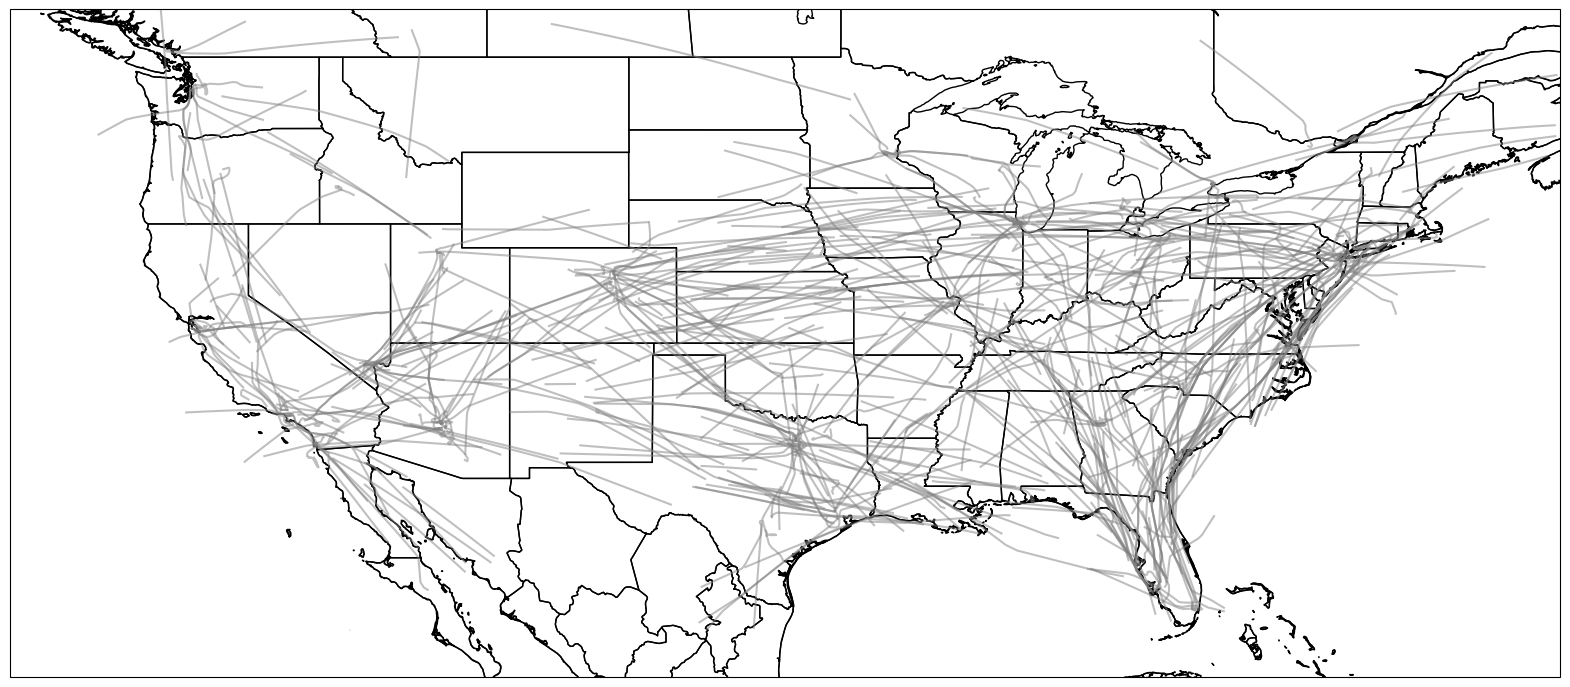

In [6]:
import os
import pandas as pd
# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'conus'
lat_bounds, lon_bounds = get_region_bounds(region)
max_callsigns = 0.9 # percentage of callsigns to plot

# List all the files in '../data/osstate/extracted' folder than ends with .csv.gz
files = [f for f in os.listdir('../data/osstate/extracted') if f.endswith('.csv.gz')]
files.sort()

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
if region=='conus':
    ax.add_feature(cfeature.STATES.with_scale('10m'))
elif region=='europe':
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))


for f in files[:25]:
    
    print(f"Processing file {f}")
    # Load the data
    df = pd.read_csv(f'../data/osstate/extracted/{f}')
    # Add a column called ident that is the concatenation of the station and the date
    df['ident'] = df['callsign'] + '_' + df['icao24']
    # Drop rows with missing values
    df.dropna(subset=['lat', 'lon'], inplace=True)
    # Filter the data to the region of interest
    df = df[(df['lat']>=lat_bounds[0]) & (df['lat']<=lat_bounds[1]) & (df['lon']>=lon_bounds[0]) & (df['lon']<=lon_bounds[1])]
    # Get the unique idents
    unique_idents = df['ident'].unique()
    n_callsigns_to_select = int(max_callsigns * len(unique_idents) / 100)
    print(f"Selecting {n_callsigns_to_select} callsigns out of {len(unique_idents)}")
    if len(unique_idents) > n_callsigns_to_select:
        unique_idents = np.random.choice(unique_idents, n_callsigns_to_select, replace=False)
    # Plot the trajectory
    for ident in unique_idents:
        print(f"Processing ident {ident}", end='\r')
        df_ident = df[df['ident']==ident]
        if len(df_ident) < 200: # Skip trajectories with less than 200 points
            continue
        # Uniformly sample the trajectory from df_ident
        df_ident = df_ident.iloc[::10, :] # Sample every 10th row
        ax.plot(df_ident['lon'], df_ident['lat'], label=ident, transform=ccrs.PlateCarree(), alpha=0.5, color='gray')

print()
print("Done.")
plt.show()